In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import os
import cv2

In [4]:
import tensorflow.contrib.slim as slim

## manually create dataset

In [ ]:
file_pattern = 'syntext_%s_*.tfrecord'

In [ ]:
split_name = 'train'

In [ ]:
file_pattern = file_pattern % split_name

In [ ]:
file_pattern

In [ ]:
# file_pattern has to have full path of data
dataset_dir = '/home/mobile/data/synthtext/'
file_pattern = os.path.join(dataset_dir, file_pattern)

In [ ]:
file_pattern

In [ ]:
reader = tf.TFRecordReader

In [ ]:
keys_to_features = {
        'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
        'image/format': tf.FixedLenFeature((), tf.string, default_value='jpeg'),
        'image/height': tf.FixedLenFeature([1], tf.int64),
        'image/width': tf.FixedLenFeature([1], tf.int64),
        'image/channels': tf.FixedLenFeature([1], tf.int64),
        'image/shape': tf.FixedLenFeature([3], tf.int64),
        'image/object/bbox/xmin': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/ymin': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/xmax': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/ymax': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/label': tf.VarLenFeature(dtype=tf.int64)
    }

In [ ]:
items_to_handlers = {
        'image': slim.tfexample_decoder.Image('image/encoded', 'image/format'),
        'shape': slim.tfexample_decoder.Tensor('image/shape'),
        'object/bbox': slim.tfexample_decoder.BoundingBox(
                ['ymin', 'xmin', 'ymax', 'xmax'], 'image/object/bbox/'),
        'object/label': slim.tfexample_decoder.Tensor('image/object/bbox/label')
    }

In [ ]:
decoder = slim.tfexample_decoder.TFExampleDecoder(
        keys_to_features, items_to_handlers)

In [ ]:
ITEMS_TO_DESCRIPTIONS = {
    'image': 'A color image of varying height and width.',
    'shape': 'Shape of the image',
    'object/bbox': 'A list of bounding boxes, one per each object.',
    'object/label': 'A list of labels, one per each object.',
}

In [ ]:
synthtext_dataset = slim.dataset.Dataset(
            data_sources=file_pattern,
            reader=reader,
            decoder=decoder,
            num_samples=200,
            items_to_descriptions=ITEMS_TO_DESCRIPTIONS,
            num_classes=1)

## import from dataset module directly

In [5]:
import sys

In [6]:
sys.path.append('../datasets/')

In [7]:
import synthtext

In [8]:
synthtext_dataset = synthtext.get_split('train', '/home/mobile/data/synthtext/')

## display some of the data

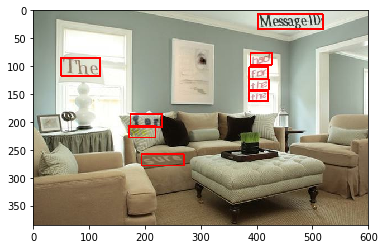

In [10]:
with tf.Graph().as_default():
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        synthtext_dataset, common_queue_capacity=32, common_queue_min=1)

    image, bbox, label = data_provider.get(['image', 'object/bbox', 'object/label'])

    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            np_image, np_bboxes, np_label = sess.run([image, bbox, label])
            height, width, _ = np_image.shape
            for bbox in np_bboxes:
                y_min, x_min, y_max, x_max = bbox
                cv2.rectangle(np_image, 
                              (int(x_min*width), int(y_min*height)), 
                              (int(x_max*width), int(y_max*height)), 
                              (255, 0, 0), 2)
            plt.figure()
            plt.imshow(np_image)